# Bin Overlap Error

This code takes Gaussian fit parameters from a previously obtained histogram, and then examines how well those Guassians can be used to define bins for counting photon numbers. The first cell has several lists of Gaussian parameters that together desribe one full histrogram. In this case, 15 million events were sampled from a coherent state distribution with mean photon number of about 14. After using the fitted Gaussian bits, the areas of the events in the histogram were used to calculate the photon number distribution of the coherent state, which is given by the list 'coher_dist' below.

In [1]:
import numpy as np
from qutip import* #need to download
import struct
import os, glob
import scipy.io
import bitarray as b #need to download
import matplotlib.pyplot as plt
import csv
from scipy.special import factorial as fac
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.integrate import simps

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def flatten(t):
    #use to flatten lists
    return [item for sublist in t for item in sublist]
'''Calculated Gaussian parameters fits from previous codes on data'''

#Measured distribution for this data
coher_dist=[2.005728360196722e-06, 4.412602392432788e-06, 3.610311048354099e-05, 0.00018252128077790168, 0.0006622915045369575, 0.0019194820407082628, 0.004695410091220526, 0.00998010317466685, 0.018671325305071283, 0.030967242444421266, 0.04676516130067473, 0.06395425334756064, 0.08044896223614643, 0.09347536564428006, 0.10081512800558395, 0.10178429594923101, 0.0954995467053906, 0.0862756031225179, 0.07154232487985687, 0.05773769886796691, 0.04362338839726258, 0.031581797613985545, 0.021903355984692282, 0.01491058462970243, 0.009027382203573405, 0.0057756953860224804, 0.003313864396717024, 0.0020101409625891548, 0.0011155861139414166, 0.0006783373314185313, 0.0003907158845663214, 0.0002479080253203148, 0]
#coher_dist=[5.3473616017593885e-06, 3.001206698987457e-05, 0.00015106296524970274, 0.0005797876816707617, 0.0016944452075575063, 0.004209576736945035, 0.009059566867720779, 0.01712980499709605, 0.028843534795850098, 0.04407469221422146, 0.060947222276252856, 0.07754402900569354, 0.09112311905720133, 0.0994908710176945, 0.10131879973923591, 0.09661131679514706, 0.08820840593212233, 0.07406978133101044, 0.060124664377862215, 0.04619786213820002, 0.033832422644231544, 0.023712006076741725, 0.01606494477612569, 0.009963270978418115, 0.006468369119548223, 0.0036993715981171672, 0.002285863400712095, 0.0011974079466739711, 0.0007202896077569896, 0.00040867211041446127, 0.00023234286159644544, 0]

'''Gaussian fit parameters for binning. Each Gaussian has three parameters, and they occur in order in each list. The first
is the location of the ceneter of the Gaussian in arbitrary area units used for the histogram, the second is the Gaussian 
peak amplitude, and the third is the standard deviation.'''

gparams_temp1=[6.08268770e+05,  2.45024365e+00,  1.12708544e+05, 1.56300607e+06,
  2.37937662e+01, 9.05904304e+04 ]
gparams_temp2=[2.41043719e+06, 1.41715463e+02, 8.73496397e+04, 3.16019593e+06,
 5.19109750e+02, 9.72316856e+04, 3.85652682e+06, 1.58079006e+03,
 9.40180788e+04]
gparams_temp3=[4.49960453e+06,
 3.99563251e+03, 9.44425103e+04, 5.07787115e+06, 8.57688496e+03, 9.47181494e+04 ]
gparams_temp4=[5630506.09640559,   16016.10272244,   97158.56749569, 
               6161137.05076052,   27001.54183779,   97167.60939734, 
               6674973.14828196, 40964.75701783,   98093.59459127, 
               7170491.77639382,   56800.26467025,  97911.73929927,
               7648979.23851249 ,  72124.33278633,   99040.31382459]
gparams_temp5=[8108023.50008762,   84787.72518092,   98904.57569745, 8552144.03989489,   93112.12210683,   97695.19977713, 8979752.00179682,
   95255.7521997 ,   97227.98508008, 9393836.44675478,   91158.58222094,
   98409.72811466]
gparams_temp6=[9788275.76988778,
    81123.92324075 ,  103752.39055317, 10179787.99087714,    71545.20150504 ,   93673.74158892, 10552643.30368328,
    57519.17636692,    96039.84687626, 10916503.80586508,    44685.73830857,
    94439.4994612 , 11269516.16300907,    32828.38105522,    94419.97121048,
 11616137.93309524,    23230.73362739,    95283.32052594]
gparams_temp7=[1.19428338e+07, 1.53362445e+04, 1.05822141e+05,
               1.22804839e+07, 1.00113073e+04, 8.69557886e+04,
               1.25960704e+07, 6.17215490e+03, 1.00249661e+05,
               1.29103100e+07, 3.62335316e+03,8.80348198e+04,
               1.32202881e+07, 2.11691440e+03, 1.13544341e+05]
gparams_temp8=[1.35193111e+07, 1.15662164e+03, 8.65090415e+04,
               1.38045792e+07, 6.64399822e+02, 1.16787485e+05,
               1.40957079e+07, 3.14143831e+02, 8.58188067e+04,
               1.43757675e+07, 2.25769568e+02, 1.60925503e+05]

gauss_params_fin=[]
for i in range(8):
    gauss_params_fin.append(eval('gparams_temp'+str(i+1)))
gauss_params_fin=flatten(gauss_params_fin)



Next, define a few functions. The functions below take in a list of Gaussian parameters and an x vector, and then return the sum of gaussians. The first function gives the sum directly, but the second function first normalizes each Gaussian in the sum before returning the result.

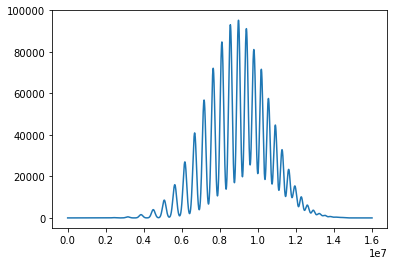

<BarContainer object of 33 artists>

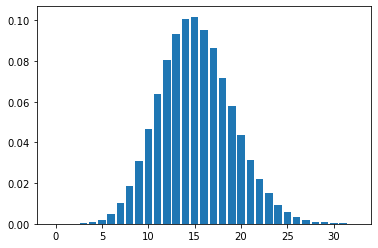

In [2]:
def gauss_sum(params,x):
    f = np.zeros_like(x)
    for k in range(round(len(params)/3)):
        ctr = params[3*k] #center of Gaussian on x-axis
        amp = params[3*k+1] #amplitude of peak
        wid = params[3*k+2] #standard deviation of the peak
        f = f + amp * np.exp( -((x - ctr)/wid)**2/2)
    return f

def gauss_sum_normed(params,x):
    f = np.zeros_like(x)
    for k in range(round(len(params)/3)):
        ctr = params[3*k] #center of Gaussian on x-axis
        amp = params[3*k+1] #amplitude of peak
        wid = params[3*k+2] #standard deviation of the peak
        f = f + np.exp( -((x - ctr)/wid)**2/2)/np.sqrt(2*np.pi*wid**2)
    return f

xvec=np.linspace(0,1.6e7,10000)
g_sum=gauss_sum(gauss_params_fin,xvec)

plt.plot(xvec,g_sum)
plt.show()
plt.bar(range(len(coher_dist)),coher_dist)

Next, find the intersection points between the neighboring Gaussians to determine the bins for the data. These locations will occur where there is a minima in the Gaussian sum.

In [3]:
'''Instead of the intersection points between neighboring Gaussians, use the minima of the sum of Gaussians'''
#This function takes in the gaussian parameters, the maximum cuttoff for the x value, and the number 
#of points in the x-axis array corresponding to histogram areas
def xbin_locs2(params,xmax,points):
    x=np.linspace(0,xmax,points)
    f = np.zeros_like(x)
    for k in range(round(len(params)/3)):
        #print(k)
        ctr = params[3*k]
        amp = params[3*k+1]
        wid = params[3*k+2]
        f=f+amp*np.exp( -((x - ctr)/wid)**2/2) 
    pks=find_peaks(-f)[0]*xmax/points #these are the locations of the minima  
        #diffs=-np.abs(f1-f2)
        #loc=np.where(diffs==np.max(diffs[round(points*ctr1/xmax):round(points*ctr2/xmax)]))[0]*xmax/points
        #vec.append(loc)
    return pks

#Calculate the location of the bins for the photon counts
photonbins=xbin_locs2(gauss_params_fin,1.5e7,100000)

Now, plot the results, both the normalized Gaussians with bins and the normal sum.

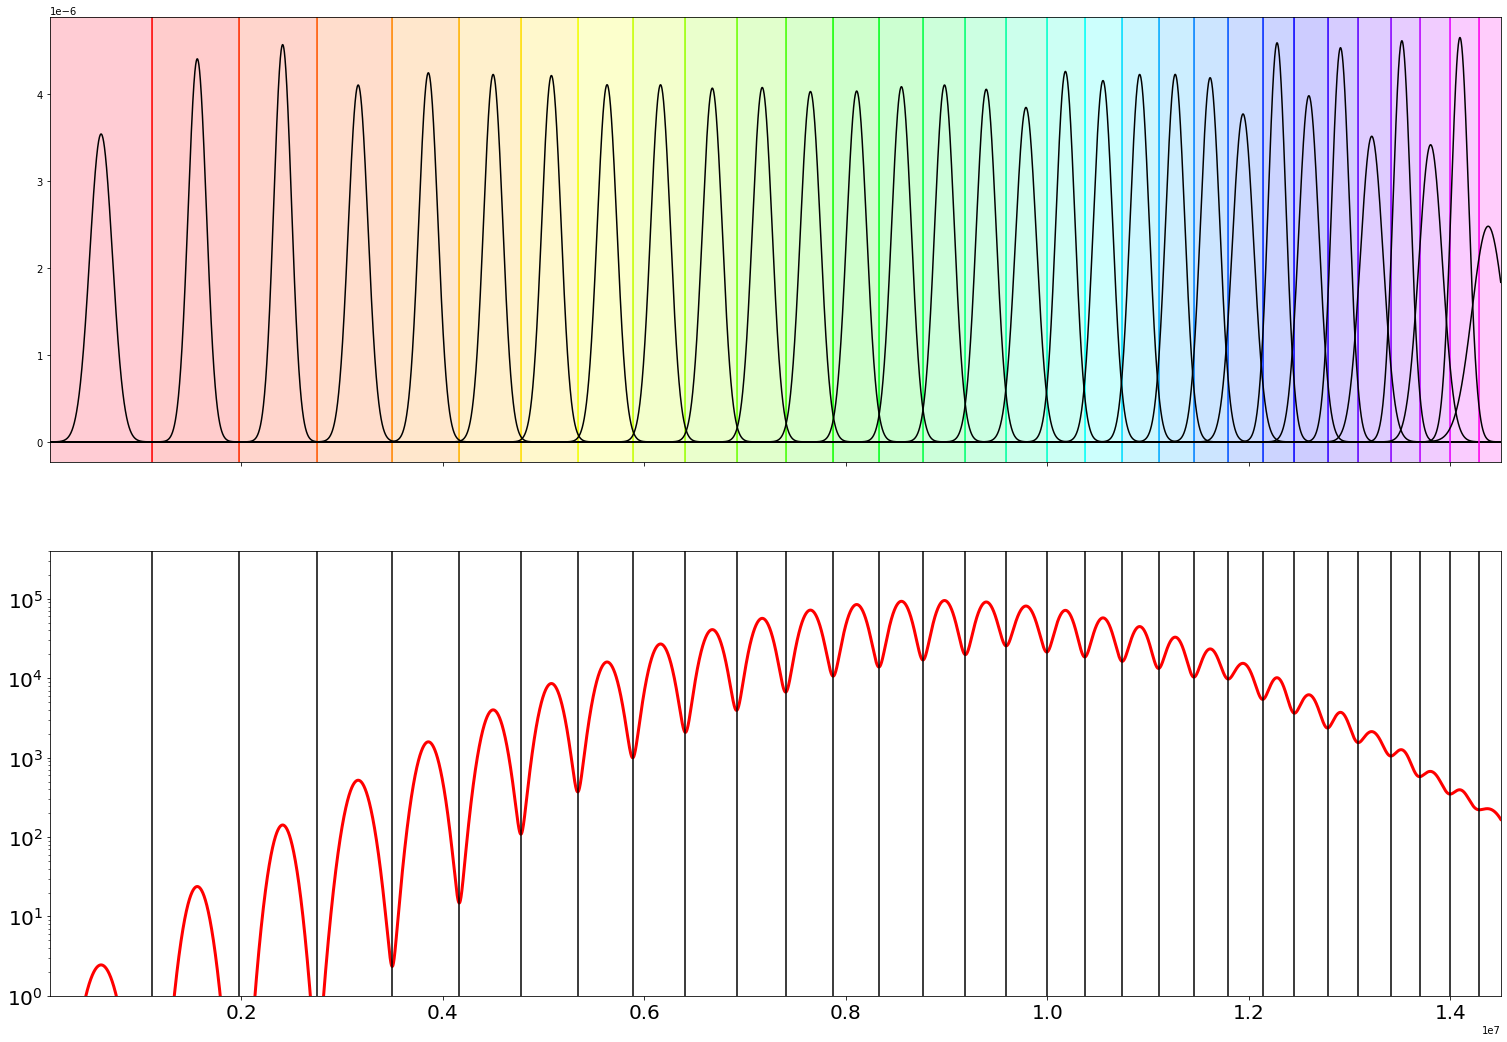

In [4]:
params=gauss_params_fin
NUM_COLORS = 31

#cm = plt.get_cmap('turbo')
cm = plt.get_cmap('gist_rainbow')
#ax = fig.add_subplot(111)
#ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
fig, ax = plt.subplots(2, sharex=True,figsize=(26, 18))

#ax.plot(xvec,gauss_sum_normed(gparams2,xvec),color='k',linewidth=2)

for k in range(len(photonbins)+1):
    if k==0:
        lend=0
    else:
        lend=photonbins[k-1]
    if k==len(photonbins):
        rend=1.6e7
    else:
        rend=photonbins[k]
    ax[0].axvline(rend, color=cm((1.*k+1)/NUM_COLORS))
    ax[0].axvspan(lend, rend, alpha=0.2,color=cm(1.*k/NUM_COLORS) )
    ctr = params[3*k]
    amp = params[3*k+1]
    wid = params[3*k+2]
    f =  np.exp( -((xvec - ctr)/wid)**2/2)/np.sqrt(2*np.pi*wid**2)
    ax[0].plot(xvec,f,color='k')
#ax.plot(xvec,gauss_sum(gauss_params_fin,xvec),color='r',linewidth=3)
plt.xlim([1e5,1.48e7])
#plt.show()

#fig, ax = plt.subplots(figsize=(22, 6))
ax[1].plot(xvec,gauss_sum(gauss_params_fin,xvec),color='r',linewidth=3)
#ax.hist(histvals, bins=1500, label='histogram')


for k in range(len(photonbins)+1):
    if k==0:
        lend=0
    else:
        lend=photonbins[k-1]
    if k==len(photonbins):
        rend=1.6e7
    else:
        rend=photonbins[k]
    ax[1].axvline(rend, color='k')
    #ctr = params[3*k]
    #amp = params[3*k+1]
    #wid = params[3*k+2]
    #f =  amp * np.exp( -((xvec - ctr)/wid)**2/2)
    #ax.plot(xvec,f,color='r')
    #ax.axvspan(lend, rend, alpha=0.15,color=cm(1.*k/NUM_COLORS) )
plt.yscale("log")
plt.ylim([1,4e5])
plt.xlim([1e5,1.45e7])
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='minor', labelsize=20)
plt.show()

The error for an individual event will be the overlap of each Gaussian with neighboring bins. The next function takes in the bins found previously, the left limit cuttoff, and the Gaussian parameters.

In [64]:
'''take those bins I just found, and integrate the gaussian in the bin over limits of the bin boundaries'''
def bin_occupancy(bins,llim,gparams):
    points=100000
    xmax=1.6e7
    x=np.linspace(0,xmax,points)
    ovlp=[]
    right_error=[]
    left_error=[]
    for k in range(len(bins)+1):
        if k==0:
            lend=llim
        else:
            lend=bins[k-1]
        if k==len(bins):
            rend=1.46e7
        else:
            rend=bins[k]
        
        ctr = gparams[3*k]
        amp = gparams[3*k+1]
        wid = gparams[3*k+2]
        f = np.exp( -((x - ctr)/wid)**2/2)/np.sqrt(2*np.pi*wid**2) 
        
        lidx=round(lend*points/xmax)
        ridx=round(rend*points/xmax)
        ldat=np.array(f)
        ldat[lidx:]=0
        rdat=np.array(f)
        rdat[:ridx]=0
        f[:lidx]=0
        f[ridx:]=0
        ovlp.append(simps(f,x,1))
        left_error.append(simps(ldat,x,1))
        right_error.append(simps(rdat,x,1))
    return ovlp,left_error,right_error


'''lerror gives a list of the overlap of each gaussian with everything to the left of its bin, which is to a good
approximation just the overlap with the neighboring bin to the left. rerror the gives the overlap with the bin to the
right. good_ovlp is the overlap of the gaussian with its own bin.'''
overlaps=bin_occupancy(photonbins,0,gauss_params_fin)
rerror=np.asarray(overlaps[2])
lerror=np.asarray(overlaps[1])
good_ovlp=np.asarray(overlaps[0])


np.set_printoptions(precision=4)
print('Probability of a photon count to be in the assigned bin: ',good_ovlp)

print('Approximate probability of a photon count to be miscounted and assigned to the bin to the left: ',lerror)

print('Approximate probability of a photon count to be miscounted and assigned to the bin to the right: ',rerror)

Probability of a photon count to be in the assigned bin:  [1.     1.     1.     0.9997 0.9994 0.998  0.9964 0.9942 0.9922 0.9896
 0.9866 0.9821 0.978  0.9745 0.9697 0.96   0.9476 0.9556 0.9471 0.9425
 0.9356 0.9252 0.8839 0.9264 0.8906 0.9065 0.8325 0.8753 0.7762 0.8605
 0.623 ]
Approximate probability of a photon count to be miscounted and assigned to the bin to the left:  [0.0000e+00 2.8334e-07 3.4015e-07 1.2755e-05 6.8171e-05 1.8492e-04
 6.9307e-04 1.3564e-03 2.2381e-03 3.2466e-03 4.5824e-03 6.4794e-03
 9.0457e-03 1.1029e-02 1.3815e-02 1.7809e-02 2.9066e-02 2.4108e-02
 2.9782e-02 3.3901e-02 3.9686e-02 4.5479e-02 8.3153e-02 5.0032e-02
 7.7006e-02 7.1196e-02 1.2038e-01 1.0380e-01 1.7497e-01 1.2740e-01
 2.9527e-01]
Approximate probability of a photon count to be miscounted and assigned to the bin to the right:  [4.2883e-06 2.4937e-06 4.8722e-05 2.5740e-04 5.5091e-04 1.7722e-03
 2.9013e-03 4.4128e-03 5.5359e-03 7.1334e-03 8.8129e-03 1.1470e-02
 1.2906e-02 1.4445e-02 1.6499e-02 2.2186e-0

We can assume that the error is limited to nearest-neighbor bins, as the next-nearest-neighbor overlap will be considerably smaller. Now, for even photon number outcomes, the overlap to the left and right is the probability to be miscounted as an odd, and the same holds true for odd photons being miscounted as even. Also, the parity error will depend on the specific distribution, as the Gaussian overlap errors are not the same for every photon-number bin.

In [65]:
'''Find the parity error, which will depend on the measured distribution as well'''
ldist_error=np.multiply(lerror,coher_dist[:len(lerror)])
rdist_error=np.multiply(rerror,coher_dist[:len(rerror)])
tot_err=rdist_error+rdist_error


odd_error=np.sum(tot_err[::2]) #total error prob of even to be counted as an odd (sums all error over even counts)
even_error=np.sum(tot_err[1::2]) #total error prob of an odd to be counted as an even (sums all error over odd counts)

print('Average error on the parity for this distribution is given by: ', odd_error-even_error)

Average error on the parity for this distribution is given by:  0.00043309896413963947
